In [1]:
# Imports
import gc
import menpo.io as mio
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import seaborn as sns
import shutil

from menpo.visualize import print_progress
from menpo.landmark import labeller, face_ibug_68_to_face_ibug_68_trimesh, face_ibug_68_to_face_ibug_66_trimesh
from menpofit.aam import PatchAAM
from menpo.feature import fast_dsift
from menpofit.aam import LucasKanadeAAMFitter, WibergInverseCompositional
from menpodetect import load_dlib_frontal_face_detector
from menpofit.builder import warp_images
from menpofit.builder import build_reference_frame
from menpo.transform import PiecewiseAffine
from menpo.model import PCAModel
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_fscore_support

from os.path import join, dirname, realpath

%matplotlib inline

/Users/206479300/anaconda2/envs/conda_env/lib/python2.7/site-packages/scipy/sparse/lil.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/Users/206479300/anaconda2/envs/conda_env/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/Users/206479300/anaconda2/envs/conda_env/lib/python2.7/site-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/Users/206479300/anaconda2/envs/conda_env/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:169: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._traversal imp

### Train AAM model (Using subset of images)

#### Data preprocessing

In [2]:
reformat_pts_files_sh = '''
shopt -s nullglob

ex -sc '1i|{{' -cx "{pts_file}"
ex -sc '1i|n_points:  66' -cx "{pts_file}"
ex -sc '1i|version: 1' -cx "{pts_file}"
echo "}}" >> {pts_file}
'''

images_path = join(dirname(os.getcwd()), 'Images')
aam_path = join(dirname(os.getcwd()), 'AAM_landmarks')
labels_path = join(dirname(os.getcwd()), 'Frame_Labels', 'PSPI')

training_images = []
training_labels = []

In [25]:
# NOTE: this cell takes around 45 mins to run
import subprocess

for subject in os.listdir(aam_path):
    if subject != '.DS_Store':
        for sequence in os.listdir(join(aam_path, subject)):
            if sequence != '.DS_Store':
                for aam_file_src in os.listdir(join(aam_path, subject, sequence)):
                    if aam_file_src != '.DS_Store':
                        aam_file_dst = '{}.pts'.format(aam_file_src.split('_')[0])
                        aam_file_src_path = join(aam_path, subject, sequence, aam_file_src)
                        aam_file_dst_path = join(images_path, subject, sequence, aam_file_dst)
                        
                        shutil.copyfile(aam_file_src_path, aam_file_dst_path)
                        subprocess.check_call(reformat_pts_files_sh.format(pts_file=aam_file_dst_path), shell=True)

In [3]:
pain_label_indices = []

pain_label_count = 0
pain_sample_count = 0

#num_pain_samples = 5000
num_pain_samples = 6000

# find pain samples
for subject_index, subject in enumerate(os.listdir(labels_path)):
    pain_label_indices.append([])
    if subject != '.DS_Store':
        for sequence_index, sequence in enumerate(os.listdir(join(labels_path, subject))):
            pain_label_indices[subject_index].append([])
            if sequence != '.DS_Store':
                for pspi_file_index, pspi_file in enumerate(os.listdir(join(labels_path, subject, sequence))):
                    if pspi_file != '.DS_Store':
                        with open(join(labels_path, subject, sequence, pspi_file), 'r') as f_in:
                            if float(f_in.read().strip()) > 0.0:
                                pain_label_indices[subject_index][sequence_index].append(pspi_file_index)

# add pain samples
for subject_index, subject in enumerate(os.listdir(labels_path)):
    if subject != '.DS_Store' and pain_sample_count < num_pain_samples:
        for sequence_index, sequence in enumerate(os.listdir(join(labels_path, subject))):
            if sequence != '.DS_Store' and pain_sample_count < num_pain_samples:
                for pspi_file_index, pspi_file in enumerate(os.listdir(join(labels_path, subject, sequence))):
                    if pain_label_count < num_pain_samples and pspi_file != '.DS_Store' and pspi_file_index in pain_label_indices[subject_index][sequence_index]:
                        with open(join(labels_path, subject, sequence, pspi_file), 'r') as f_in:
                            training_labels.append(float(f_in.read().strip()))
                            pain_label_count += 1

                for img_index, img in enumerate(print_progress(mio.import_images(join(images_path, subject, sequence) + '/', verbose=True))):
                    if pain_sample_count < num_pain_samples and img_index in pain_label_indices[subject_index][sequence_index]:
                        # convert to greyscale
                        if img.n_channels == 3:
                            img = img.as_greyscale()
                        # crop to landmarks bounding box with an extra 20% padding
                        img = img.crop_to_landmarks_proportion(0.2)
                        # rescale image if its diagonal is bigger than 400 pixels
                        d = img.diagonal()
                        if d > 400:
                            img = img.rescale(400.0 / d)
                        # append to list
                        training_images.append(img)
                        pain_sample_count += 1

Found 683 assets, index the returned LazyList to import.
[====================] 100% (683/683) - done.                                   
Found 187 assets, index the returned LazyList to import.
[====================] 100% (187/187) - done.                                   
Found 155 assets, index the returned LazyList to import.
[====================] 100% (155/155) - done.                                   
Found 350 assets, index the returned LazyList to import.
[====================] 100% (350/350) - done.                                   
Found 128 assets, index the returned LazyList to import.
[====================] 100% (128/128) - done.                                   
Found 168 assets, index the returned LazyList to import.
[====================] 100% (168/168) - done.                                   
Found 143 assets, index the returned LazyList to import.
[====================] 100% (143/143) - done.                                   
Found 320 assets, index the return

[====================] 100% (450/450) - done.                                   
Found 157 assets, index the returned LazyList to import.
[====================] 100% (157/157) - done.                                   
Found 172 assets, index the returned LazyList to import.
[====================] 100% (172/172) - done.                                   
Found 262 assets, index the returned LazyList to import.
[====================] 100% (262/262) - done.                                   
Found 195 assets, index the returned LazyList to import.
[====================] 100% (195/195) - done.                                   
Found 458 assets, index the returned LazyList to import.
[====================] 100% (458/458) - done.                                   
Found 382 assets, index the returned LazyList to import.
[====================] 100% (382/382) - done.                                   
Found 240 assets, index the returned LazyList to import.
[====================] 100% (240/2

In [4]:
no_pain_label_indices = []

no_pain_label_count = 0
no_pain_sample_count = 0

#num_no_pain_samples = 5000
num_no_pain_samples = 6000

# find no pain samples
for subject_index, subject in enumerate(os.listdir(labels_path)):
    no_pain_label_indices.append([])
    if subject != '.DS_Store':
        for sequence_index, sequence in enumerate(os.listdir(join(labels_path, subject))):
            no_pain_label_indices[subject_index].append([])
            if sequence != '.DS_Store':
                for pspi_file_index, pspi_file in enumerate(os.listdir(join(labels_path, subject, sequence))):
                    if pspi_file != '.DS_Store':
                        with open(join(labels_path, subject, sequence, pspi_file), 'r') as f_in:
                            if float(f_in.read().strip()) == 0.0:
                                no_pain_label_indices[subject_index][sequence_index].append(pspi_file_index)

# add no pain samples
for subject_index, subject in enumerate(os.listdir(labels_path)):
    if subject != '.DS_Store' and no_pain_sample_count < num_no_pain_samples:
        for sequence_index, sequence in enumerate(os.listdir(join(labels_path, subject))):
            if sequence != '.DS_Store' and no_pain_sample_count < num_no_pain_samples:
                for pspi_file_index, pspi_file in enumerate(os.listdir(join(labels_path, subject, sequence))):
                    if no_pain_label_count < num_no_pain_samples and pspi_file != '.DS_Store' and pspi_file_index in no_pain_label_indices[subject_index][sequence_index]:
                        with open(join(labels_path, subject, sequence, pspi_file), 'r') as f_in:
                            training_labels.append(float(f_in.read().strip()))
                            no_pain_label_count += 1

                for img_index, img in enumerate(print_progress(mio.import_images(join(images_path, subject, sequence) + '/', verbose=True))):
                    if no_pain_sample_count < num_no_pain_samples and img_index in no_pain_label_indices[subject_index][sequence_index]:
                        # convert to greyscale
                        if img.n_channels == 3:
                            img = img.as_greyscale()
                        # crop to landmarks bounding box with an extra 20% padding
                        img = img.crop_to_landmarks_proportion(0.2)
                        # rescale image if its diagonal is bigger than 400 pixels
                        d = img.diagonal()
                        if d > 400:
                            img = img.rescale(400.0 / d)
                        # append to list
                        training_images.append(img)
                        no_pain_sample_count += 1

Found 683 assets, index the returned LazyList to import.
[====================] 100% (683/683) - done.                                   
Found 187 assets, index the returned LazyList to import.
[====================] 100% (187/187) - done.                                   
Found 155 assets, index the returned LazyList to import.
[====================] 100% (155/155) - done.                                   
Found 350 assets, index the returned LazyList to import.
[====================] 100% (350/350) - done.                                   
Found 128 assets, index the returned LazyList to import.
[====================] 100% (128/128) - done.                                   
Found 168 assets, index the returned LazyList to import.
[====================] 100% (168/168) - done.                                   
Found 143 assets, index the returned LazyList to import.
[====================] 100% (143/143) - done.                                   
Found 320 assets, index the return

In [5]:
print 'Number of images loaded: {}'.format(len(training_images))
print 'Number of 0 (no pain) labels loaded: {}'.format(len(filter(lambda x: x == 0.0, training_labels)))
print 'Number of 1 (pain) labels loaded: {}'.format(len(filter(lambda x: x != 0.0, training_labels)))

print sum([len(sequence) for subject in pain_label_indices for sequence in subject])
print sum([len(sequence) for subject in no_pain_label_indices for sequence in subject])

Number of images loaded: 12000
Number of 0 (no pain) labels loaded: 6000
Number of 1 (pain) labels loaded: 6000
8369
40029


In [6]:
def shuffle_arrays(arrays, set_seed=-1):
    """Shuffles arrays in-place, in the same order, along axis=0

    Parameters:
    -----------
    arrays : List of NumPy arrays.
    set_seed : Seed value if int >= 0, else seed is random.
    """
    assert all(len(arr) == len(arrays[0]) for arr in arrays)
    seed = np.random.randint(0, 2**(32 - 1) - 1) if set_seed < 0 else set_seed

    for arr in arrays:
        rstate = np.random.RandomState(seed)
        rstate.shuffle(arr)

In [7]:
shuffle_arrays([training_images, training_labels])

In [96]:
# training images = :11117
## 549 ones, 10008 zeros

# test images = 11117:
## 2092 zeros, 

training_percentage_zeros = 0.10
training_percentage_ones = 0.02
test_percentage = 0.25

k_zeros = int(len(images[:11117]) * training_percentage_zeros)
k_ones = int(len(images[:11117]) * training_percentage_ones)
k_test = int(len(images[11117:]) * test_percentage)

sample_indices_zeros = [idx for idx in range(len(images[:11117])) if labels[:11117][idx] == 0]
sample_indices_ones = [idx for idx in range(len(images[:11117])) if labels[:11117][idx] != 0]

#training_indices_zeros = random.sample(xrange(len(sample_indices_zeros)), k_zeros)
#training_indices_ones = random.sample(xrange(len(sample_indices_ones)), k_ones)
training_indices_zeros = random.sample(sample_indices_zeros, k_zeros)
training_indices_ones = random.sample(sample_indices_ones, k_ones)
test_indices = random.sample(xrange(len(images[11117:])), k_test)

training_images = [images[:11117][index] for index in training_indices_zeros + training_indices_ones]
test_images = [images[11117:][index] for index in test_indices]

training_labels = [labels[:11117][index] for index in training_indices_zeros + training_indices_ones]
test_labels = [labels[11117:][index] for index in test_indices]

In [75]:
training_samples = training_images
test_samples = test_images

In [97]:
print sum([label > 0.0 for label in training_labels])

print k_ones
print len(sample_indices_ones)
print [labels[idx] for idx in sample_indices_ones[:10]]
print len(training_indices_ones)
print len(training_indices_zeros)
print [labels[idx] for idx in training_indices_ones[:10]]

222
222
1109
[1.0, 2.0, 2.0, 4.0, 4.0, 4.0, 5.0, 6.0, 6.0, 6.0]
222
1111
[1.0, 4.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 2.0, 1.0]


#### Train AAM

In [8]:
patch_aam = PatchAAM(training_images[:2000], group='PTS', patch_shape=[(15, 15), (23, 23)],
                     diagonal=150, scales=(0.5, 1.0), holistic_features=fast_dsift,
                     max_shape_components=20, max_appearance_components=150,
                     verbose=True)

- Computing reference shape                                                     Computing batch 0
- Building modelsges size: [==========] 100% (2000/2000) - done.                
  - Scale 0: Doneding appearance model                                          ngining
  - Scale 1: Doneding appearance model                                          ng
                                                              

In [9]:
fitter = LucasKanadeAAMFitter(patch_aam, lk_algorithm_cls=WibergInverseCompositional,
                              n_shape=[5, 20], n_appearance=[30, 150])

/Users/206479300/anaconda2/envs/conda_env/lib/python2.7/site-packages/menpo/shape/pointcloud.py:261: MenpoDeprecationWarning: The .lms property is deprecated. LandmarkGroups are now shapes themselves - so you can use them directly anywhere you previously used .lms.Simply remove ".lms" from your code and things will work as expected (and this warning will go away)
  MenpoDeprecationWarning)


Fitting result of 66 landmark points.
Initial error: 0.2222
Reconstructed initial error: 0.2221
Final error: 0.2612


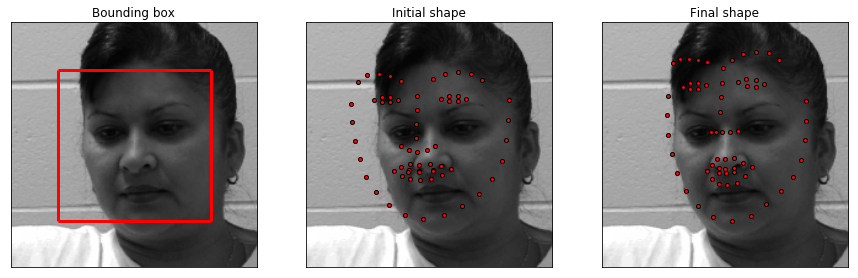

In [10]:
# Load detector
detect = load_dlib_frontal_face_detector()

# Load and convert to grayscale
image = mio.import_image(join(images_path, '042-ll042', 'll042t1aaaff', 'll042t1aaaff242.png'))
image = image.as_greyscale()

# Detect face
bboxes = detect(image)

# Crop the image for better visualization of the result
image = image.crop_to_landmarks_proportion(0.3, group='dlib_0')
bboxes[0] = image.landmarks['dlib_0'].lms

if len(bboxes) > 0:
    # Fit AAM
    result = fitter.fit_from_bb(image, bboxes[0], max_iters=[15, 5],
                                gt_shape=image.landmarks['PTS'].lms)
    print(result)

    # Visualize
    plt.subplot(131)
    image.view()
    bboxes[0].view(line_width=3, render_markers=False)
    plt.gca().set_title('Bounding box')

    plt.subplot(132)
    image.view()
    result.initial_shape.view(marker_size=4)
    plt.gca().set_title('Initial shape')

    plt.subplot(133)
    image.view()
    result.final_shape.view(marker_size=4, figure_size=(15, 13))
    plt.gca().set_title('Final shape')

In [11]:
# force garbage collection to free up some memory
del patch_aam
del fitter

gc.collect()

11957

### Feature Extraction

In [8]:
result.final_shape

PointCloud: n_points: 66, n_dims: 2

In [9]:
print training_images[0].landmarks.get('PTS')

PointCloud: n_points: 66, n_dims: 2


In [12]:
# extract shapes from images
shapes_an = [i.landmarks.get('PTS') for i in training_images]

# build reference frame
reference_frame_an = build_reference_frame(result.final_shape)

# Apply piece-wise affine warp on source images
warped_images_an = warp_images(training_images, shapes_an, reference_frame_an, PiecewiseAffine)

/Users/206479300/anaconda2/envs/conda_env/lib/python2.7/site-packages/menpofit/builder.py:338: MenpoFitModelBuilderWarning: The reference shape passed is not a TriMesh or subclass and therefore the reference frame (mask) will be calculated via a Delaunay triangulation. This may cause small triangles and thus suboptimal warps.
  MenpoFitModelBuilderWarning)
/Users/206479300/anaconda2/envs/conda_env/lib/python2.7/site-packages/menpo/image/boolean.py:711: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  copy.pixels[slices].flat = point_in_pointcloud(pointcloud, indices)


In [13]:
warped_images_an[0]

121W x 158H 2D MaskedImage with 1 channels. Attached mask 69.1% true

In [10]:
# extract shapes from images
shapes_a0 = [i.landmarks.get('PTS') for i in training_images]

# build reference frame
reference_frame_a0 = build_reference_frame(result.gt_shape)

# Apply piece-wise affine warp on source images
warped_images_a0 = warp_images(training_images, shapes_a0, reference_frame_a0, PiecewiseAffine)

In [11]:
warped_images_a0[0]

122W x 116H 2D MaskedImage with 1 channels. Attached mask 70.4% true

In [14]:
s_pts = result.final_shape.points
s_app = warped_images_an
#c_app = warped_images_a0

### Prep data for model training + evaluation (Using S-APP Features)

#### Transform PSPI labels into 0/1 (pain vs no pain) and attach labels to images

In [15]:
final_training_images = s_app
final_training_labels = [int(label > 0.0) for label in training_labels]

In [16]:
print final_training_labels[:10]
print 'Number of labels showing pain: {}'.format(sum(final_training_labels))
print 'Number of labels showing no pain: {}\n'.format(len(final_training_labels) - sum(final_training_labels))

[0, 1, 1, 1, 0, 0, 0, 1, 0, 0]
Number of labels showing pain: 6000
Number of labels showing no pain: 6000



#### Train/Test Data Split

In [17]:
vectorized_training_images = [sample.as_vector().tolist() for sample in final_training_images]
np.unique(list(map(len, vectorized_training_images)))

array([12567])

In [18]:
# force garbage collection to free up some memory
del training_images
del final_training_images
del warped_images_an
del s_app
del result

gc.collect()

47996

In [110]:
training_samples = [sample.as_vector().tolist() for sample in final_training_images]
print np.unique(list(map(len, training_samples)))

[12675]
[12675]


In [19]:
# Add labels to samples for clustering
samples = []
for image_idx, training_image in enumerate(vectorized_training_images):
    sample = training_image + [final_training_labels[image_idx]]
    samples.append(sample)

In [20]:
del vectorized_training_images

gc.collect()

2

#### Perform k-fold cross validation

In [21]:
# Future enhancement: use k-fold cross-validation instead of one static split
# In the paper, the test set was made up of ~15,760 images, the rest were used in training
#training_percentage = 0.9
training_percentage = 0.8
k = int(len(samples) * training_percentage)

training_indices = random.sample(xrange(len(samples)), k)
test_indices = list(set(range(len(samples))) - set(training_indices))

training_samples = [samples[index] for index in training_indices]
test_samples = [samples[index] for index in test_indices]

In [23]:
# force garbage collection to free up some memory
#del samples

gc.collect()

0

In [ ]:
training_percentage_zeros = 0.05
training_percentage_ones = 0.05

k_zeros = int(len(samples) * training_percentage_zeros)
k_ones = int(len(samples) * training_percentage_ones)

sample_indices_zeros = [idx for idx in range(len(samples)) if samples[idx] == 0]
sample_indices_ones = [idx for idx in range(len(samples)) if samples[idx] == 1]

training_indices_zeros = random.sample(xrange(len(sample_indices_zeros)), k_zeros)
training_indices_ones = random.sample(xrange(len(sample_indices_ones)), k_ones)
test_indices = list(set(range(len(samples[:1000]))) - set(training_indices_zeros) - set(training_indices_ones))

training_samples = [samples[index] for index in training_indices_zeros + training_indices_ones]
test_samples = [samples[index] for index in test_indices]

In [ ]:
num_folds = 10
samples_per_fold = int(float(len(samples)) / float(num_folds))
sample_indices = set(range(len(samples))
splits = []

for fold in 
training_indices = random.sample(xrange(len(samples)), k)
test_indices = list(set(range(len(samples))) - set(training_indices))

training_samples = [samples[index] for index in training_indices]
test_samples = [samples[index] for index in test_indices]

In [37]:
print(len(training_samples))
print(len(test_samples))

8000
2000


#### Cluster Samples (Video Frames) to reduce dataset for SVM

In [22]:
training_samples[-1][-1]

0

In [21]:
kmeans = KMeans(n_clusters=1000, random_state=0).fit(training_samples)

### Model Training

#### Pull training samples from clusters

In [22]:
kmeans.labels_

array([150, 497, 100, 632, 875, 763, 430,  82, 466, 123, 668, 629, 373,
       764, 592, 522,  62, 897, 413, 428, 162,  63, 468, 627, 523, 176,
       435, 371, 199, 778, 880,  95, 290, 259, 412, 576, 696, 198,  99,
       691,  83, 212,  51, 798, 528, 205,  21, 130, 381, 532, 842, 216,
       210, 830, 379, 881,  33, 421, 799, 852, 638,  61, 105,  84, 124,
       664, 582, 872, 470, 103, 659, 474,  90, 609,  79, 143,  46, 202,
       657, 425, 796, 331, 488, 801,  18, 605,  86, 761, 429, 191, 793,
       416, 874, 669, 160, 833, 720, 548, 590, 449, 883, 501, 860, 550,
       245, 789, 303, 887, 242, 237,  32, 108, 335, 565, 530, 840, 434,
       858, 457, 835, 378, 797, 814, 553, 336, 493, 637, 209, 577, 882,
       213, 121, 211,  73,  45, 787, 494, 411, 672, 885, 158, 325, 757,
         6, 583, 280, 177, 646, 884, 185, 507, 601, 776, 250, 509, 233,
       324, 567, 727,  64, 368, 258, 301, 822, 402,  43, 310, 768, 886,
       563, 893, 626, 201, 518, 126,  74, 271, 440, 391, 490, 59

In [23]:
cluster_ids = set(range(900))
final_training_samples = []

for training_sample_idx, cluster_id in enumerate(kmeans.labels_.tolist()):
    if cluster_id in cluster_ids:
        final_training_samples.append(training_samples[training_sample_idx])
        cluster_ids.remove(cluster_id)

In [24]:
print len(final_training_samples)
print final_training_samples[0][-1]
print len(final_training_samples[0])

900
0
11211


#### Separate images from labels again

In [24]:
svm_training_labels = [sample[-1] for sample in training_samples]
svm_training_samples = [sample[:-1] for sample in training_samples]

svm_test_labels = [sample[-1] for sample in test_samples]
svm_test_samples = [sample[:-1] for sample in test_samples]

#### SVM Training

In [25]:
clf = svm.SVC(gamma='scale')
clf.fit(svm_training_samples, svm_training_labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Model Evaluation

In [26]:
predictions = clf.predict(svm_test_samples).tolist()

In [27]:
predictions[10]

0

In [28]:
sum(predictions)

5

In [29]:
sum(svm_test_labels)

98

[Text(0,0.5,'no pain'), Text(0,1.5,'pain')]

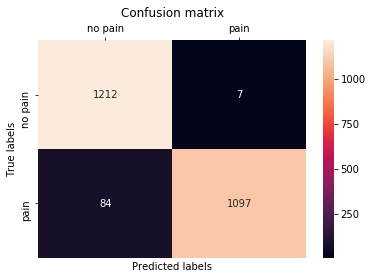

In [27]:
cm = confusion_matrix(svm_test_labels, predictions)

# plot heatmap of confusion matrix
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax = ax)

# labels, title and ticks
plt.title('Confusion matrix', y=1.08)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.tick_top()
ax.xaxis.set_ticklabels(['no pain', 'pain'])
ax.yaxis.set_ticklabels(['no pain', 'pain'])

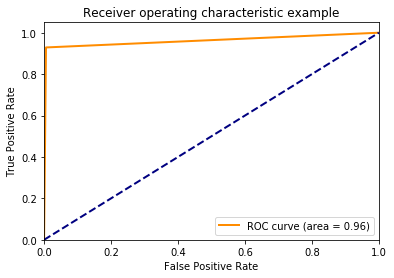

In [28]:
# Compute ROC curve and ROC area for pain class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(svm_test_labels, predictions)
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [29]:
accuracy = float(sum([predictions[i] == svm_test_labels[i] for i in range(len(svm_test_labels))])) / float(len(predictions))
scores = precision_recall_fscore_support(svm_test_labels, 
                                         predictions, 
                                         beta=1.0, 
                                         labels=None, 
                                         pos_label=1, 
                                         average='binary', 
                                         warn_for=('precision', 'recall', 'f-score'), 
                                         sample_weight=None)

print 'Model accuracy: {}\n'.format(accuracy)
print 'Model precision: {}\n'.format(scores[0])
print 'Model recall: {}\n'.format(scores[1])
print 'Model F1 Score: {}\n'.format(scores[2])

Model accuracy: 0.962083333333

Model precision: 0.99365942029

Model recall: 0.928873835732

Model F1 Score: 0.960175054705

